In [1]:
import matplotlib.pyplot as plt
import pickle

In [2]:
from host_controller.controller import VMHostPuppeteer
import cv2
import numpy as np
import time
import pyastar2d
from math import cos,sin,radians,ceil, dist


In [3]:
def sortByHSV(img, h1, s1, v1, h2, s2, v2, blur_level = 0, dilate_thresh = 0):
  if blur_level != 0:
    img = cv2.medianBlur(img,blur_level)
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV )

  # формируем начальный и конечный цвет фильтра
  h_min = np.array((h1, s1, v1), np.uint8)
  h_max = np.array((h2, s2, v2), np.uint8)

  # накладываем фильтр на кадр в модели HSV
  thresh = cv2.inRange(hsv, h_min, h_max)
  if dilate_thresh != 0:
    kernel = np.ones((dilate_thresh,dilate_thresh),np.uint8)
    thresh = cv2.dilate(thresh,kernel,iterations = 2)
  return thresh
def sortByHLS(img, h1, s1, v1, h2, s2, v2, blur_level = 0, dilate_thresh = 0):
  if blur_level != 0:
    img = cv2.medianBlur(img,blur_level)
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS )

  # формируем начальный и конечный цвет фильтра
  h_min = np.array((h1, s1, v1), np.uint8)
  h_max = np.array((h2, s2, v2), np.uint8)

  # накладываем фильтр на кадр в модели HSV
  thresh = cv2.inRange(hsv, h_min, h_max)
  if dilate_thresh != 0:
    kernel = np.ones((dilate_thresh,dilate_thresh),np.uint8)
    thresh = cv2.dilate(thresh,kernel,iterations = 2)
  return thresh

In [249]:
def getPassableOnMap(game_img, map_size = 'big_map'):

  h1, s1, v1 = 0,0,255
  h2, s2, v2 = 255,0,255
  sorted_by_hsv = sortByHSV(game_img,h1, s1, v1, h2, s2, v2 )
  
  # TODO
  if map_size == 'big_map':
    center_point_on_a_big_map = (514,364) # x,y
  else:
    center_point_on_a_map = (514,364) # x,y

  # sort the not connected stuff
  ret, currently_passable = cv2.threshold(cv2.convertScaleAbs(sorted_by_hsv),50,1,cv2.THRESH_BINARY)
  floodval = 255
  # TODO FILL THE POINT OF THE PLAYER POSITION COS IT DOESN"T MATCH the filter
  player_pos_cell_size = 5
  nearest_passable_player_points = np.where(currently_passable[int(center_point_on_a_big_map[1])-player_pos_cell_size:int(center_point_on_a_big_map[1])+player_pos_cell_size, int(center_point_on_a_big_map[0])-player_pos_cell_size:int(center_point_on_a_big_map[0])+player_pos_cell_size] == 1)
  nearest_passable_player_point = list(list(zip(nearest_passable_player_points[0], nearest_passable_player_points[1]))[0])
  nearest_passable_player_point[0] = int(center_point_on_a_big_map[1]) + nearest_passable_player_point[0] - player_pos_cell_size
  nearest_passable_player_point[1] = int(center_point_on_a_big_map[0]) + nearest_passable_player_point[1] - player_pos_cell_size
  cv2.floodFill(currently_passable, None, (nearest_passable_player_point[1], nearest_passable_player_point[0]), floodval)
  currently_passable_area = ((currently_passable==floodval) * 255).astype(np.uint8)
  return currently_passable_area

def getHPMP(game_img):
  
  cropped_mp_bar = game_img[622:620+140, 900+30:900+31] # line only
  h1, s1, v1 = 94,130,54
  h2, s2, v2 = 123,255,199
  sorted_by_hsv = sortByHSV(cropped_mp_bar,h1, s1, v1, h2, s2, v2 )
  mp_level = 100
  pixel_value = 100/140
  for i in sorted_by_hsv:
    if i[0] == 0:
      mp_level -= pixel_value
    else:
      break

  # cropped_hp_bar = game_img[620:620+130, 60+15:60+16] # line only
  cropped_hp_bar = game_img[621:620+130, 60+15:150]# VISIBLE

  h1, s1, v1 = 0,116,0
  h2, s2, v2 = 255,255,255
  sorted_by_hsv = sortByHSV(cropped_hp_bar,h1, s1, v1, h2, s2, v2 )
  hp_level = 100
  pixel_value = 100/sorted_by_hsv.shape[0]
  for i in sorted_by_hsv:
    if i[0] == 0:
      hp_level -= pixel_value
    else:
      break
  return [hp_level, mp_level]

def detectHeistExitTransitionArea(currently_passable_area_mask):
  # accepts currently_passable_area_mask
  h1, s1, v1 = 165,135,187
  h2, s2, v2 = 180,212,229
  sorted_by_hsv = sortByHSV(currently_passable_area_mask,h1, s1, v1, h2, s2, v2 )
  kernel = np.ones((10,10),np.uint8)
  sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
  targets = [] # (x,y)
  for c in contours:
    if cv2.contourArea(c) > 50:
      x, y, w, h = cv2.boundingRect(c)
      target = (int(x + w / 2), int(y + h / 2))
      targets.append(target)

  return targets

def detectHeistPrimaryTarget(currently_passable_area_mask):
  # accepts currently_passable_area_mask
  h1, s1, v1 = 12,255,206
  h2, s2, v2 = 23,255,212
  sorted_by_hsv = sortByHSV(currently_passable_area_mask,h1, s1, v1, h2, s2, v2 )
  kernel = np.ones((10,10),np.uint8)
  sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
  targets = [] # (x,y)
  for c in contours:
    if cv2.contourArea(c) > 50:
      x, y, w, h = cv2.boundingRect(c)
      target = (int(x + w / 2), int(y + h / 2))
      targets.append(target)

  return targets

def detectSmallChests(currently_passable_area_mask):
  # currently_passable_area_mask
  h1, s1, v1 = 19,160,106
  h2, s2, v2 = 21,172,173
  sorted_by_hsv = sortByHSV(currently_passable_area_mask,h1, s1, v1, h2, s2, v2 )

  kernel = np.ones((10,10),np.uint8)
  sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
  (contours, hierarchy) = cv2.findContours(
      sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  targets = []
  for c in contours:
      if cv2.contourArea(c) > 50:
          x, y, w, h = cv2.boundingRect(c)
          target = (int(x + w / 2), int(y + h / 2))
          targets.append(target)
  return targets

def detectHeistExitTransitionArea(currently_passable_area_mask):
  # accepts map_mask
  h1, s1, v1 = 165,135,187
  h2, s2, v2 = 180,212,229
  sorted_by_hsv = sortByHSV(currently_passable_area_mask,h1, s1, v1, h2, s2, v2 )
  kernel = np.ones((10,10),np.uint8)
  sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
  (contours, hierarchy) = cv2.findContours(
    sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  targets = [] # (x,y)
  for c in contours:
      if cv2.contourArea(c) > 50:
          x, y, w, h = cv2.boundingRect(c)
          target = (int(x + w / 2), int(y + h / 2))
          targets.append(target)

  return targets

def detectHeistPrimaryTarget(currently_passable_area_mask):
  # accepts map_mask
  h1, s1, v1 = 12,255,206
  h2, s2, v2 = 23,255,212
  sorted_by_hsv = sortByHSV(currently_passable_area_mask,h1, s1, v1, h2, s2, v2 )
  kernel = np.ones((10,10),np.uint8)
  sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
  (contours, hierarchy) = cv2.findContours(
    sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  targets = [] # (x,y)
  for c in contours:
      if cv2.contourArea(c) > 50:
          x, y, w, h = cv2.boundingRect(c)
          target = (int(x + w / 2), int(y + h / 2))
          targets.append(target)

  return targets

def detectWaypointsHSV(currently_passable_area_mask):
    # TODO area of search should be masked, to ignore the objects outside of the passable zone
    h1, s1, v1 = 0,205,200
    h2, s2, v2 = 21,212,231
    sorted_by_hsv = sortByHSV(currently_passable_area_mask,h1, s1, v1, h2, s2, v2 )
    kernel = np.ones((3,3),np.uint8)
    sorted_by_hsv = cv2.erode(sorted_by_hsv,kernel,iterations = 1)
    kernel = np.ones((10,10),np.uint8)
    sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
    (contours, hierarchy) = cv2.findContours(
        sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # extracting enemy x and y coordinates from contours
    targets = [] # (x,y)
    for c in contours:
        if cv2.contourArea(c) > 50:
            x, y, w, h = cv2.boundingRect(c)
            target = (int(x + w / 2), int(y + h / 2))
            targets.append(target)

    return targets

def generatePath(img, start, end):
  # img [[0]] numpy 2d array
  # start (y,x)
  # end (y,x)

  # The minimum cost must be 1 for the heuristic to be valid.
  # The weights array must have np.float32 dtype to be compatible with the C++ code.
  # The start and goal coordinates are in matrix coordinates (i, j).

  path = pyastar2d.astar_path(img, start, end, allow_diagonal=False)

  # print(path)
  # The path is returned as a numpy array of (i, j) coordinates.
  # array([[0, 0],
  #        [1, 1],
  #        [2, 2],
  #        [3, 3],
  return path

def generateAstarMap(currently_passable_area):
  ret, astar_map = cv2.threshold(currently_passable_area, 129, 255, cv2.THRESH_BINARY_INV)
  astar_map[astar_map == 0] = 1
  return astar_map

def searchHeistFinal(currently_passable_area_mask):

  # img = copy.copy(img)
  

  h1, s1, v1 = 16,255,101
  h2, s2, v2 = 28,255,239
  thresh = sortByHSV(currently_passable_area_mask, h1, s1, v1, h2, s2, v2)

  kernel = np.ones((5,5),np.uint8)
  thresh = cv2.dilate(thresh,kernel,iterations = 2)
  # plt.imshow(img);plt.show()
  # plt.imshow(thresh);plt.show()
  # plt.imshow(thresh2);plt.show()
  # plt.imshow(merged);plt.show()
  return thresh

def detectHeistChestOnScreen(game_img):
  game_img_copy = game_img.copy()
  game_img_copy[:50,:,:] = [255,255,255]

  # TODO get the doors only at the current area, skipping the outer one

  h1, s1, v1 = 21,130,149
  h2, s2, v2 = 24,147,208
  sorted_by_hsv = sortByHSV(game_img_copy,h1, s1, v1, h2, s2, v2 )
  kernel = np.ones((2,2),np.uint8)
  sorted_by_hsv = cv2.erode(sorted_by_hsv,kernel,iterations = 1)
  kernel = np.ones((3,9),np.uint8)
  sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 3)
  (contours, hierarchy) = cv2.findContours(
      sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  # extracting enemy x and y coordinates from contours
  targets = [] # (x,y)
  for c in contours:
      if cv2.contourArea(c) > 50:
          x, y, w, h = cv2.boundingRect(c)
          target = (int(x + w / 2), int(y + h / 2))
          targets.append(target)

  return targets

def detectHeistDoors(game_img):
  game_img_copy = game_img.copy()
  game_img_copy[:50,:] = [0,0,0]
  game_img_copy[620:,:] = [0,0,0]
  h1, s1, v1 = 5,139,52
  h2, s2, v2 = 31,149,85
  sorted_by_hsv = sortByHSV(game_img_copy,h1, s1, v1, h2, s2, v2 )
  kernel = np.ones((4,4),np.uint8)
  sorted_by_hsv = cv2.erode(sorted_by_hsv,kernel,iterations = 1)
  kernel = np.ones((15,15),np.uint8)
  sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
  (contours, hierarchy) = cv2.findContours(
      sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  targets = []
  for c in contours:
      if cv2.contourArea(c) > 50:
          x, y, w, h = cv2.boundingRect(c)
          target = (int(x + w / 2), int(y + h / 2))
          targets.append(target)

  return targets

In [310]:
class PoeBot:
  x1,x2,y1,y2 = 0,0,0,0
  window_pos_orig_x = 0
  window_pos_orig_y = 0
  window_pos_x = 0
  window_pos_y = 0
  window_width = 0
  window_height = 0
  def __init__(self,bot_controls:VMHostPuppeteer) -> None:
    self.bot_controls = bot_controls

  def getPosXY(self, x, y):
    return [self.x1 + x, self.y1 + y]
    
  def getImage(self):
    return self.bot_controls.getScreen(self.x1, self.y1, self.x2, self.y2)
  
  def getMinimap(self):
    return self.bot_controls.getScreen(self.x1+825, self.y1, self.x2-5, self.y1+200)

  def getHPMP(self, img=None):
    if img is None:
      img = self.getImage()

    cropped_mp_bar = img[622:620+140, 900+30:900+31] # line only
    h1, s1, v1 = 94,130,54
    h2, s2, v2 = 123,255,199
    sorted_by_hsv = sortByHSV(cropped_mp_bar,h1, s1, v1, h2, s2, v2 )
    mp_level = 100
    pixel_value = 100/140
    for i in sorted_by_hsv:
      if i[0] == 0:
        mp_level -= pixel_value
      else:
        break

    # cropped_hp_bar = game_img[620:620+130, 60+15:60+16] # line only
    cropped_hp_bar = img[621:620+130, 60+15:150]# VISIBLE

    h1, s1, v1 = 0,116,0
    h2, s2, v2 = 255,255,255
    sorted_by_hsv = sortByHSV(cropped_hp_bar,h1, s1, v1, h2, s2, v2 )
    hp_level = 100
    pixel_value = 100/sorted_by_hsv.shape[0]
    for i in sorted_by_hsv:
      if i[0] == 0:
        hp_level -= pixel_value
      else:
        break
    return [hp_level, mp_level]

  def getPassableOnMap(poe_bot, img = None, map_size = 'big_map'):

    h1, s1, v1 = 0,0,255
    h2, s2, v2 = 255,0,255
    sorted_by_hsv = sortByHSV(img,h1, s1, v1, h2, s2, v2 )
    
    # TODO
    if map_size == 'big_map':
      center_point_on_a_big_map = (514,364) # x,y
    else:
      center_point_on_a_map = (514,364) # x,y

    # sort the not connected stuff
    ret, currently_passable = cv2.threshold(cv2.convertScaleAbs(sorted_by_hsv),50,1,cv2.THRESH_BINARY)
    floodval = 255
    # TODO FILL THE POINT OF THE PLAYER POSITION COS IT DOESN"T MATCH the filter
    player_pos_cell_size = 5
    nearest_passable_player_points = np.where(currently_passable[int(center_point_on_a_big_map[1])-player_pos_cell_size:int(center_point_on_a_big_map[1])+player_pos_cell_size, int(center_point_on_a_big_map[0])-player_pos_cell_size:int(center_point_on_a_big_map[0])+player_pos_cell_size] == 1)
    nearest_passable_player_point = list(list(zip(nearest_passable_player_points[0], nearest_passable_player_points[1]))[0])
    nearest_passable_player_point[0] = int(center_point_on_a_big_map[1]) + nearest_passable_player_point[0] - player_pos_cell_size
    nearest_passable_player_point[1] = int(center_point_on_a_big_map[0]) + nearest_passable_player_point[1] - player_pos_cell_size
    cv2.floodFill(currently_passable, None, (nearest_passable_player_point[1], nearest_passable_player_point[0]), floodval)
    currently_passable_area = ((currently_passable==floodval) * 255).astype(np.uint8)
    return currently_passable_area

  def getMapMask(poe_bot, img = None, currently_passable_area = None):
    if img is None:
      img = poe_bot.getImage()
    if currently_passable_area is None:
      currently_passable_area = poe_bot.getPassableOnMap(img)
    kernel = np.ones((12,12),np.uint8)
    currently_passable_area_dilated = cv2.dilate(currently_passable_area,kernel,iterations = 1)
    currently_passable_area_mask = img.copy()
    currently_passable_area_mask[currently_passable_area_dilated < 1] = [0,0,0]
    return currently_passable_area_mask  

  def detectDoorsAndNPCS(poe_bot, img = None):
    #excluding waypoints
    if img is None:
      img = poe_bot.getImage()
    h1, s1, v1 = 114,23,158
    h2, s2, v2 = 130,24,217
    sorted_by_hsv = sortByHSV(img,h1, s1, v1, h2, s2, v2 )
    # plt.imshow(sorted_by_hsv);plt.show()
    kernel = np.ones((2,2),np.uint8)
    sorted_by_hsv = cv2.morphologyEx(sorted_by_hsv, cv2.MORPH_OPEN, kernel, iterations = 1)
    # plt.imshow(sorted_by_hsv);plt.show()
    kernel = np.ones((3,12),np.uint8)
    sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 3)
    # plt.imshow(sorted_by_hsv);plt.show()
    (contours, hierarchy) = cv2.findContours(
        sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # extracting enemy x and y coordinates from contours
    targets = [] # (x,y)
    for c in contours:
      if cv2.contourArea(c) > 50:
        x, y, w, h = cv2.boundingRect(c)
        target = (int(x + w / 2), int(y + h / 2))
        targets.append(target)
    return targets

  def detectWaypointsHSV(poe_bot, img=None):
    if img is None:
      img = poe_bot.getMapMask()
        
    # TODO area of search should be masked, to ignore the objects outside of the passable zone
    h1, s1, v1 = 0,205,200
    h2, s2, v2 = 21,212,231
    sorted_by_hsv = sortByHSV(img,h1, s1, v1, h2, s2, v2 )
    kernel = np.ones((3,3),np.uint8)
    sorted_by_hsv = cv2.erode(sorted_by_hsv,kernel,iterations = 1)
    kernel = np.ones((10,10),np.uint8)
    sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
    (contours, hierarchy) = cv2.findContours(
        sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # extracting enemy x and y coordinates from contours
    targets = [] # (x,y)
    for c in contours:
      if cv2.contourArea(c) > 50:
        x, y, w, h = cv2.boundingRect(c)
        target = (int(x + w / 2), int(y + h / 2))
        targets.append(target)

    return targets

  def assignWidnowLoc(poe_bot):
    window_loc = poe_bot.bot_controls.getWindowLoc('Path of Exile')
    print(window_loc)
    if window_loc is None:
      raise 'no window running the game'
      # TODO make it run using cmd
    poe_bot.window_pos_orig_x, poe_bot.window_pos_orig_y, poe_bot.window_width, poe_bot.window_height = window_loc[0], window_loc[1], window_loc[2] - window_loc[0], window_loc[3] - window_loc[1]
    poe_bot.x1, poe_bot.y1, poe_bot.x2, poe_bot.y2 = window_loc[0]+7, window_loc[1]+31, window_loc[2]-7, window_loc[3]-8  

In [311]:
# init game window

bot_controls = VMHostPuppeteer('192.168.2.104',50001)
poe_bot = PoeBot(bot_controls)


def assignWidnowLoc(poe_bot):
  window_loc = poe_bot.bot_controls.getWindowLoc('Path of Exile')
  print(window_loc)
  if window_loc is None:
    raise 'no window running the game'
    # TODO make it run using cmd
  poe_bot.window_pos_orig_x, poe_bot.window_pos_orig_y, poe_bot.window_width, poe_bot.window_height = window_loc[0], window_loc[1], window_loc[2] - window_loc[0], window_loc[3] - window_loc[1]
  poe_bot.x1, poe_bot.y1, poe_bot.x2, poe_bot.y2 = window_loc[0]+7, window_loc[1]+31, window_loc[2]-7, window_loc[3]-8  
# get window itself or run it
window_loc = poe_bot.bot_controls.getWindowLoc('Path of Exile')
print(window_loc)
if window_loc is None:
  raise 'no window running the game'
  # TODO make it run using cmd
poe_bot.window_pos_orig_x, poe_bot.window_pos_orig_y, poe_bot.window_width, poe_bot.window_height = window_loc[0], window_loc[1], window_loc[2] - window_loc[0], window_loc[3] - window_loc[1]
poe_bot.x1, poe_bot.y1, poe_bot.x2, poe_bot.y2 = window_loc[0]+7, window_loc[1]+31, window_loc[2]-7, window_loc[3]-8

poe_bot.assignWidnowLoc()

(23, 48, 1063, 855)
(23, 48, 1063, 855)


got screenshot from
 poe_bot.getImage 0.1953563690185547


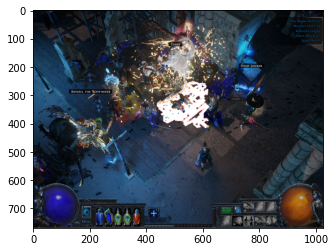

getHPMP 0.000993967056274414
hp 99.2248062015504, mp 100
getPassableOnMap 0.011053323745727539


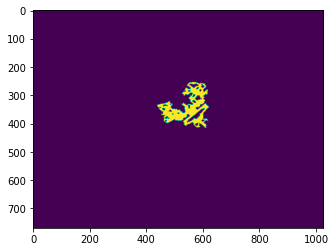

getMapMask 0.03127431869506836


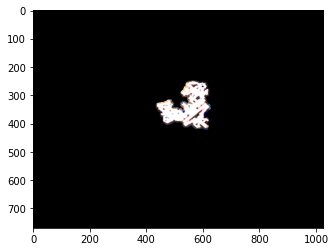

detectDoorsAndNPCS 0.013198614120483398
npcs and doors are at [(208, 289), (803, 198), (745, 197), (508, 122)]


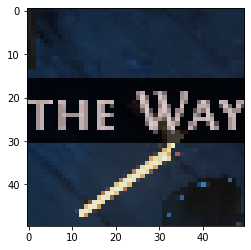

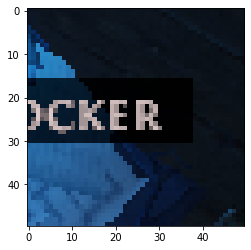

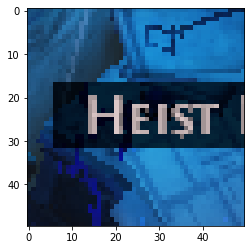

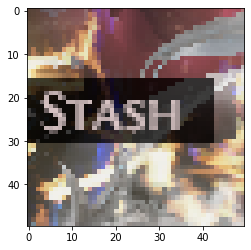

detectWaypointsHSV 0.0060160160064697266
waypoints are at [(526, 327)]


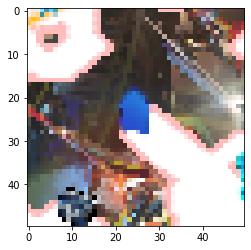

detectHeistExitTransitionArea 0.006033658981323242
HeistExitTransitionArea are at [(531, 354)]


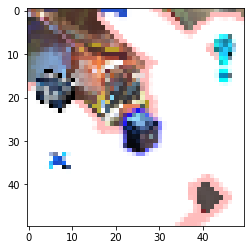

detectHeistPrimaryTarget 0.006011009216308594
eistPrimaryTarget are at []
detectSmallChests 0.005011081695556641
heist_chests_on_minimap are at [(621, 334)]


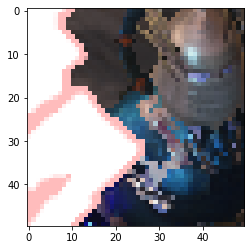

generateAstarMap 0.00201416015625


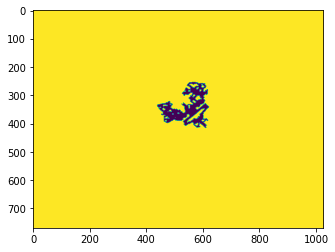

detectHeistChestOnScreen 0.009043216705322266
detectHeistChestOnScreen are at []


In [312]:

# working and tested
t1 = time.time()
game_img = poe_bot.getImage()
print(f' poe_bot.getImage {time.time() - t1}')
plt.imshow(game_img);plt.show()

t1 = time.time()
hp, mp = poe_bot.getHPMP(game_img)
print(f'getHPMP {time.time() - t1}')
print(f'hp {hp}, mp {mp}')

t1 = time.time()
currently_passable_area = getPassableOnMap(game_img)
print(f'getPassableOnMap {time.time() - t1}')
plt.imshow(currently_passable_area);plt.show()

t1 = time.time()
currently_passable_area_mask = poe_bot.getMapMask(game_img, currently_passable_area)
print(f'getMapMask {time.time() - t1}')
plt.imshow(currently_passable_area_mask);plt.show()

t1 = time.time()
npcs_and_doors = poe_bot.detectDoorsAndNPCS(game_img)
print(f'detectDoorsAndNPCS {time.time() - t1}')
print(f'npcs and doors are at {npcs_and_doors}')
for target in npcs_and_doors:
  target_loc = (int(target[0]), int(target[1]))
  plt.imshow(game_img[target_loc[1]-25:target_loc[1]+25, target_loc[0]-25:target_loc[0]+25 ]);plt.show()

t1 = time.time()
waypoints = detectWaypointsHSV(currently_passable_area_mask)
print(f'detectWaypointsHSV {time.time() - t1}')
print(f'waypoints are at {waypoints}')
for target in waypoints:
  target_loc = (int(target[0]), int(target[1]))
  plt.imshow(game_img[target_loc[1]-25:target_loc[1]+25, target_loc[0]-25:target_loc[0]+25 ]);plt.show()



t1 = time.time()
eistExitTransitionArea = detectHeistExitTransitionArea(currently_passable_area_mask)
print(f'detectHeistExitTransitionArea {time.time() - t1}')
print(f'HeistExitTransitionArea are at {eistExitTransitionArea}')
for target in eistExitTransitionArea:
  target_loc = (int(target[0]), int(target[1]))
  plt.imshow(game_img[target_loc[1]-25:target_loc[1]+25, target_loc[0]-25:target_loc[0]+25 ]);plt.show()

t1 = time.time()
eistPrimaryTarget = detectHeistPrimaryTarget(currently_passable_area_mask)
print(f'detectHeistPrimaryTarget {time.time() - t1}')
print(f'eistPrimaryTarget are at {eistPrimaryTarget}')
for target in eistPrimaryTarget:
  target_loc = (int(target[0]), int(target[1]))
  plt.imshow(game_img[target_loc[1]-25:target_loc[1]+25, target_loc[0]-25:target_loc[0]+25 ]);plt.show()

t1 = time.time()
heist_small_chests_on_minimap = detectSmallChests(currently_passable_area_mask)
print(f'detectSmallChests {time.time() - t1}')
print(f'heist_chests_on_minimap are at {heist_small_chests_on_minimap}')
for target in heist_small_chests_on_minimap:
  target_loc = (int(target[0]), int(target[1]))
  plt.imshow(game_img[target_loc[1]-25:target_loc[1]+25, target_loc[0]-25:target_loc[0]+25 ]);plt.show()


t1 = time.time()
astar_map = generateAstarMap(currently_passable_area)
print(f'generateAstarMap {time.time() - t1}')
plt.imshow(astar_map);plt.show()

t1 = time.time()
heist_chests_on_screen = detectHeistChestOnScreen(game_img)
print(f'detectHeistChestOnScreen {time.time() - t1}')
print(f'detectHeistChestOnScreen are at {heist_chests_on_screen}')
for target in heist_chests_on_screen:
  target_loc = (int(target[0]), int(target[1]))
  plt.imshow(game_img[target_loc[1]-25:target_loc[1]+25, target_loc[0]-25:target_loc[0]+25 ]);plt.show()


# # BROKEN
# t1 = time.time()
# heist_doors_on_screen = detectHeistDoors(game_img)
# print(f'detectHeistDoors {time.time() - t1}')
# print(f'detectHeistDoors are at {heist_doors_on_screen}')
# for target in heist_doors_on_screen:
#   target_loc = (int(target[0]), int(target[1]))
#   plt.imshow(game_img[target_loc[1]-25:target_loc[1]+25, target_loc[0]-25:target_loc[0]+25 ]);plt.show()

got screenshot from


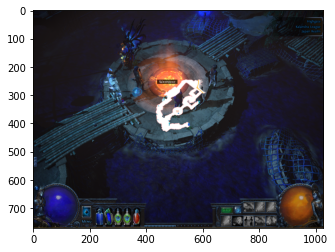

got screenshot from


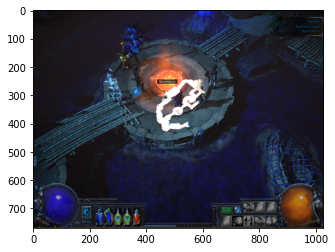

(769, 1027, 3)


In [32]:
# debug for screen position

game_img = bot_controls.getScreen(window_loc[0]+7, window_loc[1]+30, window_loc[2]-7, window_loc[3]-8)
plt.imshow(game_img);plt.show()
game_img = poe_bot.getImage()
plt.imshow(game_img);plt.show()
print(game_img.shape)


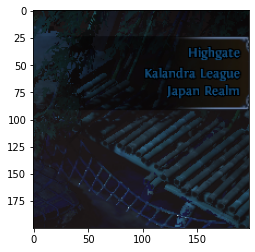

got screenshot from


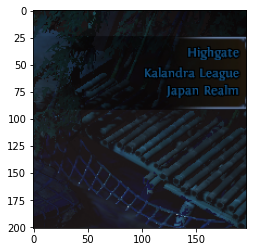

In [33]:
minimap = game_img[0:200,825:-4]
plt.imshow(minimap);plt.show()
minimap = poe_bot.getMinimap()
plt.imshow(minimap);plt.show()


got screenshot from


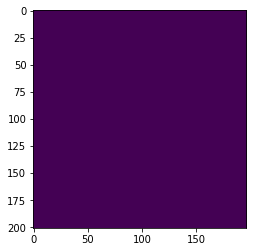

got screenshot from


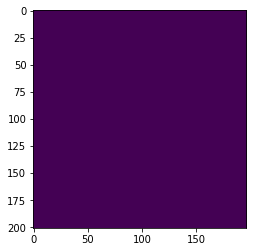

In [34]:
def sortPassableOnMinimapHSV(minimap):
  h1, s1, v1 = 0,0,255
  h2, s2, v2 = 255,0,255
  sorted_by_hsv = sortByHSV(minimap,h1, s1, v1, h2, s2, v2 )
  return sorted_by_hsv


h1, s1, v1 = 0,0,255
h2, s2, v2 = 255,0,255
minimap = poe_bot.getMinimap()
sorted_by_hsv = sortByHSV(minimap,h1, s1, v1, h2, s2, v2 )
plt.imshow(sorted_by_hsv);plt.show()

minimap = poe_bot.getMinimap()
sorted_by_hsv = sortPassableOnMinimapHSV(minimap)
plt.imshow(sorted_by_hsv);plt.show()

got screenshot from


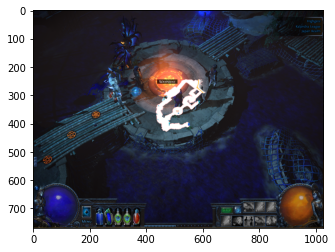

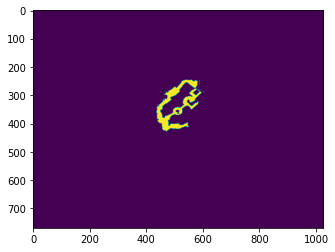

got screenshot from


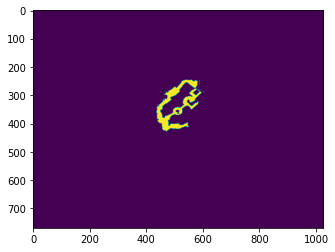

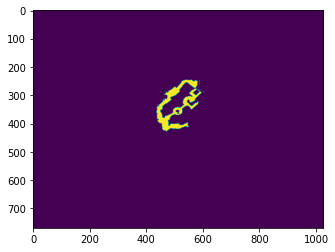

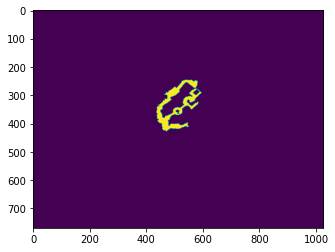

got screenshot from


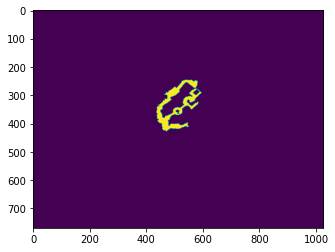

In [35]:
def getPassableOnMap(poe_bot, img = None, map_size = 'big_map'):
  
  if img is None:
    img = poe_bot.getImage()
  h1, s1, v1 = 0,0,255
  h2, s2, v2 = 255,0,255
  sorted_by_hsv = sortByHSV(img,h1, s1, v1, h2, s2, v2 )
  
  # TODO
  if map_size == 'big_map':
    center_point_on_a_big_map = (514,364) # x,y
  else:
    center_point_on_a_map = (514,364) # x,y

  # sort the not connected stuff
  ret, currently_passable = cv2.threshold(cv2.convertScaleAbs(sorted_by_hsv),50,1,cv2.THRESH_BINARY)
  floodval = 255
  # TODO FILL THE POINT OF THE PLAYER POSITION COS IT DOESN"T MATCH the filter
  player_pos_cell_size = 5
  nearest_passable_player_points = np.where(currently_passable[int(center_point_on_a_big_map[1])-player_pos_cell_size:int(center_point_on_a_big_map[1])+player_pos_cell_size, int(center_point_on_a_big_map[0])-player_pos_cell_size:int(center_point_on_a_big_map[0])+player_pos_cell_size] == 1)
  nearest_passable_player_point = list(list(zip(nearest_passable_player_points[0], nearest_passable_player_points[1]))[0])
  nearest_passable_player_point[0] = int(center_point_on_a_big_map[1]) + nearest_passable_player_point[0] - player_pos_cell_size
  nearest_passable_player_point[1] = int(center_point_on_a_big_map[0]) + nearest_passable_player_point[1] - player_pos_cell_size
  cv2.floodFill(currently_passable, None, (nearest_passable_player_point[1], nearest_passable_player_point[0]), floodval)
  currently_passable_area = ((currently_passable==floodval) * 255).astype(np.uint8)
  return currently_passable_area

game_img = poe_bot.getImage()
big_map = game_img
plt.imshow(big_map);plt.show()

h1, s1, v1 = 0,0,255
h2, s2, v2 = 255,0,255
sorted_by_hsv = sortByHSV(big_map,h1, s1, v1, h2, s2, v2 )
plt.imshow(sorted_by_hsv);plt.show()

game_img = poe_bot.getImage()
sorted_by_hsv = sortPassableOnMinimapHSV(game_img)
plt.imshow(sorted_by_hsv);plt.show()
cv2.imwrite('./sorted_by_hsv.jpg', sorted_by_hsv)

center_point_on_a_big_map = (514,364) # x,y

# sort the not connected stuff

ret, currently_passable = cv2.threshold(cv2.convertScaleAbs(sorted_by_hsv),50,1,cv2.THRESH_BINARY)
plt.imshow(currently_passable);plt.show()
floodval = 255



player_pos_cell_size = 5
nearest_passable_player_points = np.where(currently_passable[int(center_point_on_a_big_map[1])-player_pos_cell_size:int(center_point_on_a_big_map[1])+player_pos_cell_size, int(center_point_on_a_big_map[0])-player_pos_cell_size:int(center_point_on_a_big_map[0])+player_pos_cell_size] == 1)
nearest_passable_player_point = list(list(zip(nearest_passable_player_points[0], nearest_passable_player_points[1]))[0])
nearest_passable_player_point[0] = int(center_point_on_a_big_map[1]) + nearest_passable_player_point[0] - player_pos_cell_size
nearest_passable_player_point[1] = int(center_point_on_a_big_map[0]) + nearest_passable_player_point[1] - player_pos_cell_size
# print(nearest_passable_player_point)
# print(hr.player_pos)
cv2.floodFill(currently_passable, None, (nearest_passable_player_point[1], nearest_passable_player_point[0]), floodval)
# Extract filled area alone
currently_passable_area = ((currently_passable==floodval) * 255).astype(np.uint8)
plt.imshow(currently_passable_area);plt.show()

game_img = poe_bot.getImage()

currently_passable_area = getPassableOnMap(poe_bot, game_img)
plt.imshow(currently_passable_area);plt.show()

got screenshot from


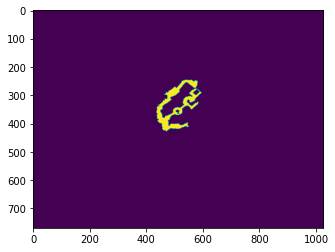

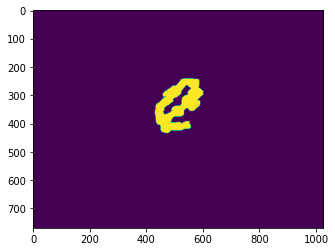

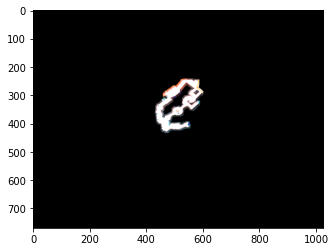

In [36]:

# CURRENT map for search area
def getMapMask(poe_bot: PoeBot, img = None, currently_passable_area = None):
  if img is None:
    img = poe_bot.getImage()
  if currently_passable_area is None:
    currently_passable_area = getPassableOnMap(poe_bot, img)
  kernel = np.ones((12,12),np.uint8)
  currently_passable_area_dilated = cv2.dilate(currently_passable_area,kernel,iterations = 1)
  currently_passable_area_mask = img.copy()
  currently_passable_area_mask[currently_passable_area_dilated < 1] = [0,0,0]
  return currently_passable_area_mask  



game_img = poe_bot.getImage()
currently_passable_area = getPassableOnMap(poe_bot, game_img)
kernel = np.ones((12,12),np.uint8)
currently_passable_area_dilated = cv2.dilate(currently_passable_area,kernel,iterations = 1)
currently_passable_area_mask = game_img.copy()
currently_passable_area_mask[currently_passable_area_dilated < 1] = [0,0,0]

plt.imshow(currently_passable_area);plt.show()
plt.imshow(currently_passable_area_dilated);plt.show()
plt.imshow(currently_passable_area_mask);plt.show()

got screenshot from


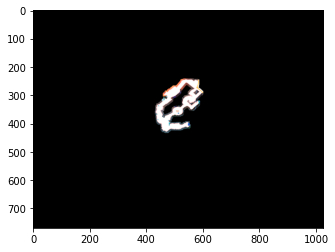

In [37]:
plt.imshow(getMapMask(poe_bot))

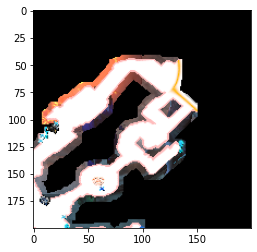

In [38]:
plt.imshow(currently_passable_area_mask[200:400, 450:650]);plt.show()

got screenshot from


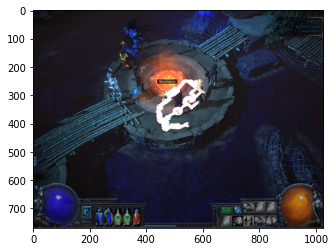

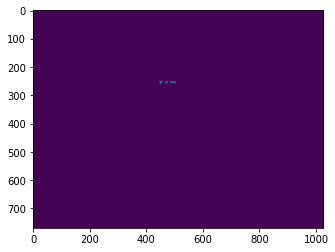

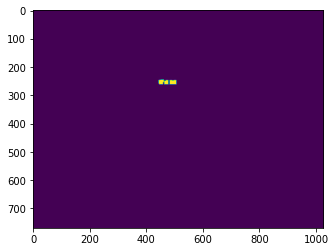

got screenshot from


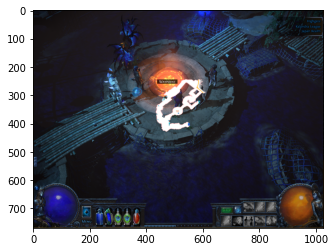

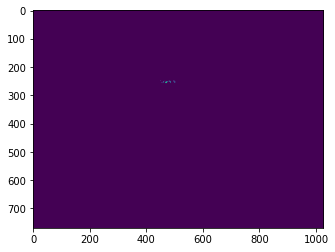

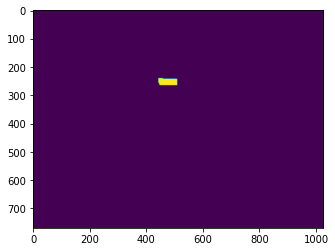

got screenshot from


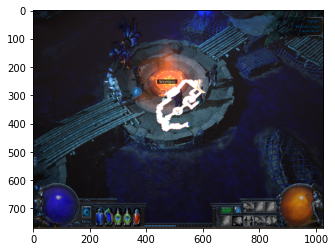

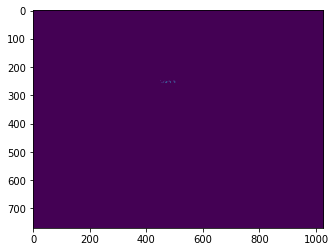

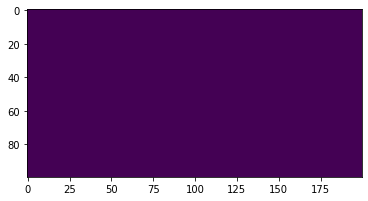

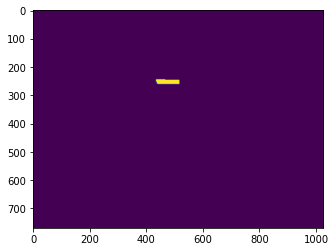

got screenshot from


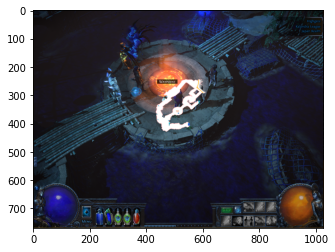

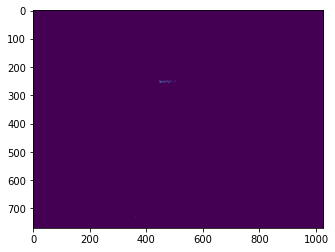

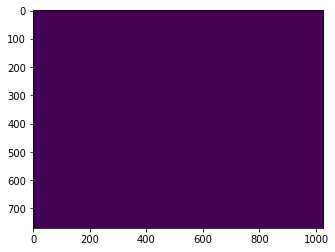

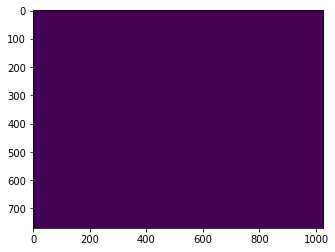

In [39]:
# TODO DETECTING DOORS OR NPCS

h1, s1, v1 = 101,10,153
h2, s2, v2 = 123,40,253

h1, s1, v1 = 109,23,142
h2, s2, v2 = 132,33,239

game_img = poe_bot.getImage()
plt.imshow(game_img);plt.show()

h1, s1, v1 = 114,23,147
h2, s2, v2 = 127,40,229
sorted_by_hsv = sortByHSV(game_img,h1, s1, v1, h2, s2, v2 )

kernel = np.ones((2,2),np.uint8)
sorted_by_hsv = cv2.morphologyEx(sorted_by_hsv, cv2.MORPH_OPEN, kernel, iterations = 1)
plt.imshow(sorted_by_hsv);plt.show()
kernel = np.ones((3,3),np.uint8)
sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 4)
plt.imshow(sorted_by_hsv);plt.show()

##
game_img = poe_bot.getImage()
plt.imshow(game_img);plt.show()

h1, s1, v1 = 114,23,189
h2, s2, v2 = 130,40,196
sorted_by_hsv = sortByHSV(game_img,h1, s1, v1, h2, s2, v2 )

kernel = np.ones((5,5),np.uint8)
sorted_by_hsv = cv2.morphologyEx(sorted_by_hsv, cv2.MORPH_CLOSE, kernel, iterations = 1)
plt.imshow(sorted_by_hsv);plt.show()
kernel = np.ones((5,5),np.uint8)
sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 4)
plt.imshow(sorted_by_hsv);plt.show()
##

game_img = poe_bot.getImage()
plt.imshow(game_img);plt.show()

h1, s1, v1 = 114,23,189
h2, s2, v2 = 130,28,196
sorted_by_hsv = sortByHSV(game_img,h1, s1, v1, h2, s2, v2 )
plt.imshow(sorted_by_hsv);plt.show()
plt.imshow(sorted_by_hsv[300:400, 400:600]);plt.show()
cv2.imwrite('./sorted_by_hsv.jpg', sorted_by_hsv)
kernel = np.ones((3,9),np.uint8)
sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 4)
plt.imshow(sorted_by_hsv);plt.show()

## 

game_img = poe_bot.getImage()
plt.imshow(game_img);plt.show()

h1, s1, v1 = 114,23,158
h2, s2, v2 = 130,24,217
sorted_by_hsv = sortByHSV(game_img,h1, s1, v1, h2, s2, v2 )
plt.imshow(sorted_by_hsv);plt.show()
kernel = np.ones((2,2),np.uint8)
sorted_by_hsv = cv2.morphologyEx(sorted_by_hsv, cv2.MORPH_OPEN, kernel, iterations = 1)
plt.imshow(sorted_by_hsv);plt.show()
kernel = np.ones((3,9),np.uint8)
sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 3)
plt.imshow(sorted_by_hsv);plt.show()
(contours, hierarchy) = cv2.findContours(
    sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# extracting enemy x and y coordinates from contours
targets = [] # (x,y)
for c in contours:
    if cv2.contourArea(c) > 50:
        x, y, w, h = cv2.boundingRect(c)
        target = ((x + w / 2), (y + h / 2))
        targets.append(target)
# cv2.imwrite('./sorted_by_hsv.jpg', sorted_by_hsv)


In [40]:
# 3 or 4

got screenshot from


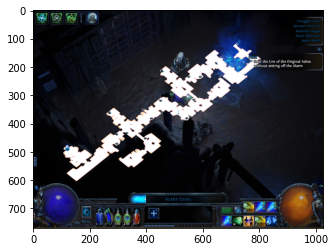

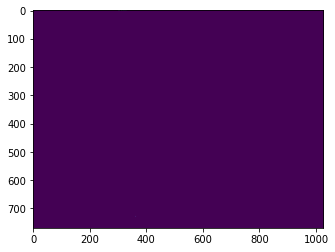

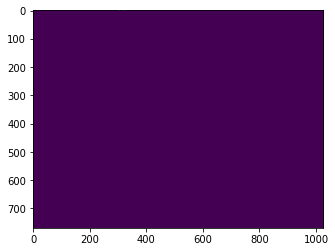

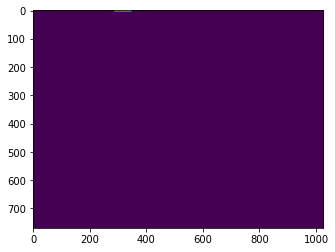

[(317, 2)]


In [161]:
def detectDoorsAndNPCS(poe_bot, img = None):
    #excluding waypoints

    if img is None:
        img = poe_bot.getImage()
    h1, s1, v1 = 114,23,158
    h2, s2, v2 = 130,24,217
    sorted_by_hsv = sortByHSV(img,h1, s1, v1, h2, s2, v2 )
    # plt.imshow(sorted_by_hsv);plt.show()
    kernel = np.ones((2,2),np.uint8)
    sorted_by_hsv = cv2.morphologyEx(sorted_by_hsv, cv2.MORPH_OPEN, kernel, iterations = 1)
    # plt.imshow(sorted_by_hsv);plt.show()
    kernel = np.ones((3,12),np.uint8)
    sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 3)
    # plt.imshow(sorted_by_hsv);plt.show()
    (contours, hierarchy) = cv2.findContours(
        sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # extracting enemy x and y coordinates from contours
    targets = [] # (x,y)
    for c in contours:
        if cv2.contourArea(c) > 50:
            x, y, w, h = cv2.boundingRect(c)
            target = (int(x + w / 2), int(y + h / 2))
            targets.append(target)
    return targets


game_img = poe_bot.getImage()
plt.imshow(game_img);plt.show()

h1, s1, v1 = 114,23,158
h2, s2, v2 = 130,24,217
sorted_by_hsv = sortByHSV(game_img,h1, s1, v1, h2, s2, v2 )
plt.imshow(sorted_by_hsv);plt.show()
kernel = np.ones((2,2),np.uint8)
sorted_by_hsv = cv2.morphologyEx(sorted_by_hsv, cv2.MORPH_OPEN, kernel, iterations = 1)
plt.imshow(sorted_by_hsv);plt.show()
kernel = np.ones((3,12),np.uint8)
sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 3)
plt.imshow(sorted_by_hsv);plt.show()
(contours, hierarchy) = cv2.findContours(
    sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# extracting enemy x and y coordinates from contours
targets = [] # (x,y)
for c in contours:
    if cv2.contourArea(c) > 50:
        x, y, w, h = cv2.boundingRect(c)
        target = (int(x + w / 2), int(y + h / 2))
        targets.append(target)

print(targets)
# pos_x, pos_y = poe_bot.getPosXY(targets[0][0], targets[0][1])
# poe_bot.bot_controls.mouseSetCursorPos(pos_x, pos_y)
# time.sleep(0.05)
# poe_bot.bot_controls.mouseClick(pos_x, pos_y)

got screenshot from


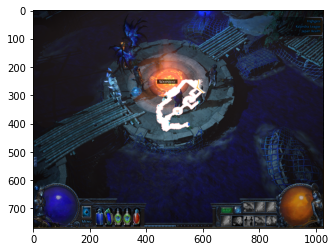

In [42]:
# DETECTING DOORS AND WAYPOINTS
game_img = poe_bot.getImage()
plt.imshow(game_img);plt.show()
f = open('./blue_drops.pickle', 'wb')
pickle.dump(game_img, f)
f.close()

got screenshot from


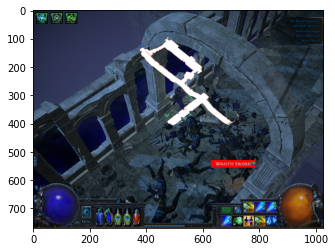

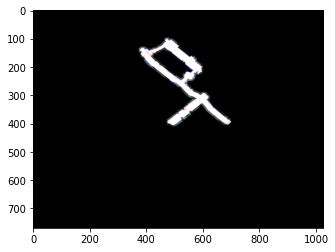

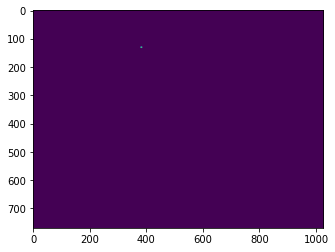

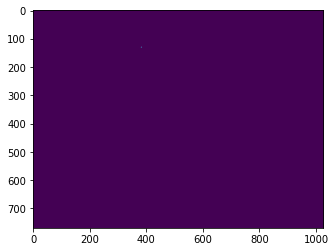

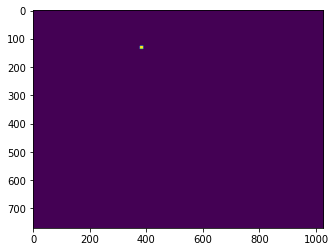

[(383.0, 131.5)]
[(383, 131)]


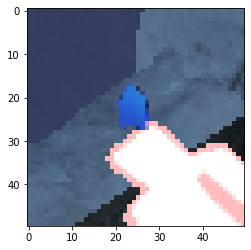

In [309]:
def detectWaypointsHSV(currently_passable_area_mask):
    # TODO area of search should be masked, to ignore the objects outside of the passable zone
    h1, s1, v1 = 0,205,200
    h2, s2, v2 = 21,212,231
    sorted_by_hsv = sortByHSV(currently_passable_area_mask,h1, s1, v1, h2, s2, v2 )
    kernel = np.ones((3,3),np.uint8)
    sorted_by_hsv = cv2.erode(sorted_by_hsv,kernel,iterations = 1)
    kernel = np.ones((10,10),np.uint8)
    sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
    (contours, hierarchy) = cv2.findContours(
        sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # extracting enemy x and y coordinates from contours
    targets = [] # (x,y)
    for c in contours:
        if cv2.contourArea(c) > 50:
            x, y, w, h = cv2.boundingRect(c)
            target = (int(x + w / 2), int(y + h / 2))
            targets.append(target)

    return targets
# DETECTING DOORS AND WAYPOINTS
game_img = poe_bot.getImage()
currently_passable_area_mask = poe_bot.getMapMask(game_img)
plt.imshow(game_img);plt.show()
plt.imshow(currently_passable_area_mask);plt.show()

# TODO get the doors only at the current area, skipping the outer one

h1, s1, v1 = 0,205,200
h2, s2, v2 = 21,212,231
sorted_by_hsv = sortByHSV(currently_passable_area_mask,h1, s1, v1, h2, s2, v2 )
plt.imshow(sorted_by_hsv);plt.show()
kernel = np.ones((3,3),np.uint8)
sorted_by_hsv = cv2.erode(sorted_by_hsv,kernel,iterations = 1)
plt.imshow(sorted_by_hsv);plt.show()
kernel = np.ones((10,10),np.uint8)
sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
plt.imshow(sorted_by_hsv);plt.show()
(contours, hierarchy) = cv2.findContours(
    sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# extracting enemy x and y coordinates from contours
targets = [] # (x,y)
for c in contours:
    if cv2.contourArea(c) > 50:
        x, y, w, h = cv2.boundingRect(c)
        target = ((x + w / 2), (y + h / 2))
        targets.append(target)

print(targets)

targets = detectWaypointsHSV(currently_passable_area_mask)
print(targets)
if targets != []:

    target = (int(targets[0][0]), int(targets[0][1]))
    plt.imshow(game_img[target[1]-25:target[1]+25, target[0]-25:target[0]+25 ])


[(595, 365)]


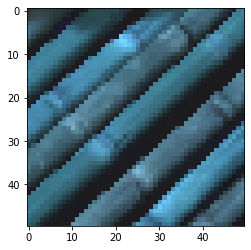

In [277]:
# game_img = poe_bot.getImage()
# currently_passable_area_mask = poe_bot.getMapMask(game_img)
targets = detectWaypointsHSV(currently_passable_area_mask)
print(targets)
if targets != []:

    target = (int(targets[0][0]), int(targets[0][1]))
    plt.imshow(game_img[target[1]-25:target[1]+25, target[0]-25:target[0]+25 ])

got screenshot from
distance_to_target 4.123105625617661


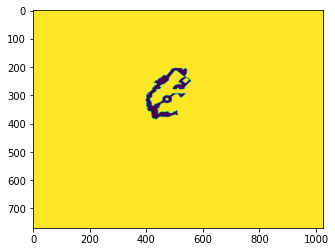

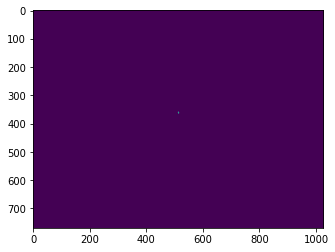

In [260]:
import pyastar2d
def generatePath(img, start, end):
  # img [[0]] numpy 2d array
  # start (y,x)
  # end (y,x)

  # The minimum cost must be 1 for the heuristic to be valid.
  # The weights array must have np.float32 dtype to be compatible with the C++ code.
  # The start and goal coordinates are in matrix coordinates (i, j).

  path = pyastar2d.astar_path(img, start, end, allow_diagonal=False)

  # print(path)
  # The path is returned as a numpy array of (i, j) coordinates.
  # array([[0, 0],
  #        [1, 1],
  #        [2, 2],
  #        [3, 3],
  return path

def generateAstarMap(currently_passable_area):
  ret, astar_map = cv2.threshold(currently_passable_area, 129, 255, cv2.THRESH_BINARY_INV)
  astar_map[astar_map == 0] = 1
  return astar_map


def _generateImageWithPath(img, path):
  empty_zeros = np.zeros_like(img)
  line_width = 1
  for point in path:
    empty_zeros[point[0]-line_width: point[0]+line_width, point[1]-line_width:point[1]+line_width] = 255
  # print(path)
  return empty_zeros

center_point_on_a_big_map = (514,364) # x,y
# target = (608, 300)
target = target

game_img = poe_bot.getImage()
currently_passable_area = poe_bot.getPassableOnMap(game_img)

ret, astar_map = cv2.threshold(currently_passable_area, 129, 255, cv2.THRESH_BINARY_INV)
astar_map[astar_map == 0] = 1
path = pyastar2d.astar_path(astar_map.astype(np.float32), (center_point_on_a_big_map[1], center_point_on_a_big_map[0]), (target[1], target[0]), allow_diagonal=False)
distance_to_target = dist((center_point_on_a_big_map[1], center_point_on_a_big_map[0]), (target[1], target[0]))
print(f'distance_to_target {distance_to_target}')
plt.imshow(astar_map);plt.show()
path_img = _generateImageWithPath(currently_passable_area, path)
plt.imshow(path_img)


In [15]:
def cropPath(path):
  cropped_path = []

  x_limit = 25
  y_limit = 25
  y_half = 364 # Y
  x_half = 514 # X
  x_range = [x_half - x_limit, x_half + x_limit] # [lower, upper]
  y_range = [y_half - y_limit, y_half + y_limit] # [lower, upper]
  x_scale_value = 20
  y_scale_value = 14
  print(y_half, x_half)
  print(x_range, y_range)

  for point in path:
    if point[0] > y_range[0] and point[0] < y_range[1] and point[1] > x_range[0] and point[1] < x_range[1]:
      new_point = [int((point[0] - y_range[0]) * y_scale_value + y_scale_value / 2),  int((point[1] - x_range[0]) * x_scale_value + x_scale_value / 2)] # y, x
      # cropped_path.append(point)
      cropped_path.append(new_point)
    else: 
      break
  cropped_path = list(filter(lambda point: point[1] > 100 and point[1] < 950 and point[0] > 100 and point[0] < 600 , cropped_path))
  return cropped_path

cropped_path = []

x_limit = 25
y_limit = 25
y_half = 364 # Y
x_half = 514 # X
x_range = [x_half - x_limit, x_half + x_limit] # [lower, upper]
y_range = [y_half - y_limit, y_half + y_limit] # [lower, upper]
x_scale_value = 20
y_scale_value = 14
print(y_half, x_half)
print(x_range, y_range)
print(path)
for point in path:
  if point[0] > y_range[0] and point[0] < y_range[1] and point[1] > x_range[0] and point[1] < x_range[1]:
    new_point = [int((point[0] - y_range[0]) * y_scale_value + y_scale_value / 2),  int((point[1] - x_range[0]) * x_scale_value + x_scale_value / 2)] # y, x
    # cropped_path.append(point)
    cropped_path.append(new_point)
  else: 
    break

cropped_path = list(filter(lambda point: point[1] > 100 and point[1] < 950 and point[0] > 100 and point[0] < 600 , cropped_path))
print(cropped_path)

364 514
[489, 539] [339, 389]
[[364 514]
 [364 515]
 [364 516]
 [364 517]
 [364 518]
 [364 519]
 [364 520]
 [364 521]
 [364 522]
 [365 522]
 [366 522]
 [367 522]
 [368 522]
 [369 522]
 [369 523]
 [370 523]
 [370 524]
 [370 525]
 [370 526]
 [370 527]
 [369 527]
 [369 528]
 [368 528]
 [368 529]
 [368 530]
 [368 531]
 [368 532]
 [368 533]
 [368 534]
 [368 535]
 [368 536]
 [368 537]
 [368 538]
 [368 539]
 [368 540]
 [368 541]
 [368 542]
 [368 543]
 [368 544]
 [368 545]
 [368 546]
 [368 547]
 [368 548]
 [368 549]
 [368 550]
 [368 551]
 [368 552]
 [368 553]
 [368 554]
 [368 555]
 [368 556]
 [368 557]
 [368 558]
 [368 559]
 [368 560]
 [368 561]
 [368 562]
 [368 563]
 [368 564]
 [368 565]
 [368 566]
 [368 567]
 [368 568]
 [368 569]
 [368 570]
 [368 571]
 [367 571]
 [367 572]
 [367 573]
 [367 574]
 [366 574]
 [366 575]
 [365 575]
 [365 576]
 [365 577]
 [365 578]
 [365 579]
 [365 580]
 [365 581]
 [365 582]
 [365 583]
 [365 584]
 [365 585]
 [365 586]
 [365 587]
 [365 588]
 [365 589]
 [365 590]
 [

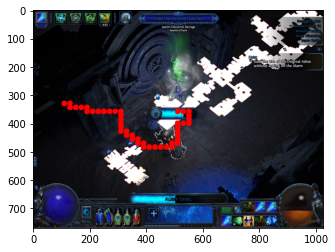

In [197]:
game_img_copy = game_img.copy()

for point in cropped_path:
  cv2.circle(game_img_copy, ( point[1], point[0]), 10, (255,0,0), -1)

plt.imshow(game_img_copy)

In [229]:
point_to_go = cropped_path[-1]
pos_x, pos_y = poe_bot.getPosXY(point_to_go[1], point_to_go[0])
poe_bot.bot_controls.mouseSetCursorPos(pos_x, pos_y)
time.sleep(0.1)
poe_bot.bot_controls.mouseClick(pos_x, pos_y)

In [313]:
display = False
distance_to_target = 99
while distance_to_target > 30:
  game_img = poe_bot.getImage()
  if display: plt.imshow(game_img);plt.show()
  currently_passable_area = poe_bot.getPassableOnMap(game_img) 
  if display: plt.imshow(currently_passable_area);plt.show()
  currently_passable_area_mask =  poe_bot.getMapMask(game_img, currently_passable_area)
  if display: plt.imshow(currently_passable_area_mask);plt.show()
  targets = detectWaypointsHSV(currently_passable_area_mask)
  target = targets[0]
  astar_map = generateAstarMap(currently_passable_area)
  center_point_on_a_big_map = (514,364) # x,y
  distance_to_target = dist((center_point_on_a_big_map[1], center_point_on_a_big_map[0]), (target[1], target[0]))
  print(f'distance_to_target {distance_to_target}')
  if distance_to_target < 30:
    break
  path = pyastar2d.astar_path(astar_map.astype(np.float32), (center_point_on_a_big_map[1], center_point_on_a_big_map[0]), (target[1], target[0]), allow_diagonal=False)
  cropped_path = cropPath(path)
  print(cropped_path)
  point_to_go = cropped_path[10]
  pos_x, pos_y = poe_bot.getPosXY(point_to_go[1], point_to_go[0])
  poe_bot.bot_controls.mouseSetCursorPos(pos_x, pos_y)
  time.sleep(0.1)
  # poe_bot.bot_controls.mousePress(pos_x, pos_y)
  poe_bot.bot_controls.mouseClick(pos_x, pos_y)
poe_bot.bot_controls.mouseRelease()

got screenshot from
distance_to_target 66.88796603276258
364 514
[489, 539] [339, 389]
[[357, 510], [343, 510], [343, 530], [343, 550], [329, 550], [329, 570], [315, 570], [315, 590], [301, 590], [301, 610], [287, 610], [287, 630], [273, 630], [259, 630], [259, 650], [245, 650], [245, 670], [245, 690], [245, 710], [245, 730], [245, 750], [231, 750], [231, 770], [217, 770], [203, 770], [203, 790], [189, 790], [175, 790], [161, 790], [161, 810], [161, 830], [161, 850], [161, 870], [161, 890], [161, 910], [161, 930]]
got screenshot from
distance_to_target 66.88796603276258
364 514
[489, 539] [339, 389]
[[357, 510], [343, 510], [343, 530], [343, 550], [329, 550], [329, 570], [315, 570], [315, 590], [301, 590], [301, 610], [287, 610], [287, 630], [273, 630], [259, 630], [259, 650], [245, 650], [245, 670], [245, 690], [245, 710], [245, 730], [245, 750], [231, 750], [231, 770], [217, 770], [203, 770], [203, 790], [189, 790], [175, 790], [161, 790], [161, 810], [161, 830], [161, 850], [161, 87

In [196]:
display = False
distance_to_target = 99
while distance_to_target > 30:
  game_img = poe_bot.getImage()
  if display: plt.imshow(game_img);plt.show()
  currently_passable_area = poe_bot.getPassableOnMap(game_img) 
  if display: plt.imshow(currently_passable_area);plt.show()
  currently_passable_area_mask =  poe_bot.getMapMask(game_img, currently_passable_area)
  if display: plt.imshow(currently_passable_area_mask);plt.show()
  targets = detectHeistPrimaryTarget(currently_passable_area_mask)
  target = targets[0]
  astar_map = generateAstarMap(currently_passable_area)
  center_point_on_a_big_map = (514,364) # x,y
  distance_to_target = dist((center_point_on_a_big_map[1], center_point_on_a_big_map[0]), (target[1], target[0]))
  print(f'distance_to_target {distance_to_target}')
  if distance_to_target < 30:
    break
  path = pyastar2d.astar_path(astar_map.astype(np.float32), (center_point_on_a_big_map[1], center_point_on_a_big_map[0]), (target[1], target[0]), allow_diagonal=False)
  cropped_path = cropPath(path)
  print(cropped_path)
  point_to_go = cropped_path[10]
  pos_x, pos_y = poe_bot.getPosXY(point_to_go[1], point_to_go[0])
  poe_bot.bot_controls.mouseSetCursorPos(pos_x, pos_y)
  time.sleep(0.1)
  # poe_bot.bot_controls.mousePress(pos_x, pos_y)
  poe_bot.bot_controls.mouseClick(pos_x, pos_y)
poe_bot.bot_controls.mouseRelease()


got screenshot from
distance_to_target 186.26057016985638
364 514
[489, 539] [339, 389]
[[357, 510], [357, 530], [343, 530], [329, 530], [329, 550], [329, 570], [329, 590], [343, 590], [343, 610], [357, 610], [371, 610], [385, 610], [399, 610], [413, 610], [427, 610], [427, 590], [441, 590], [441, 570], [441, 550], [441, 530], [455, 530], [469, 530], [469, 510], [483, 510], [483, 490], [483, 470], [483, 450], [497, 450], [511, 450], [525, 450], [539, 450], [553, 450], [567, 450], [581, 450], [595, 450]]
got screenshot from
distance_to_target 186.26057016985638
364 514
[489, 539] [339, 389]
[[357, 510], [357, 530], [343, 530], [329, 530], [329, 550], [329, 570], [329, 590], [343, 590], [343, 610], [357, 610], [371, 610], [385, 610], [399, 610], [413, 610], [427, 610], [427, 590], [441, 590], [441, 570], [441, 550], [441, 530], [455, 530], [469, 530], [469, 510], [469, 490], [469, 470], [469, 450], [469, 430], [469, 410], [469, 390], [469, 370], [469, 350], [483, 350], [497, 350], [497, 

IndexError: list index out of range

In [324]:

display = False
distance_to_target = 99


while distance_to_target > 20:
  game_img = poe_bot.getImage()

  npcs_and_doors = poe_bot.detectDoorsAndNPCS(game_img)
  if len(npcs_and_doors) != 0:
    print('door detected')
    # stop then
    poe_bot.bot_controls.mouseRelease()
    pos_x, pos_y = poe_bot.getPosXY(center_point_on_a_big_map[0], center_point_on_a_big_map[1])
    poe_bot.bot_controls.mouseSetCursorPos(pos_x, pos_y)
    time.sleep(0.01)
    poe_bot.bot_controls.mouseClick(pos_x, pos_y)
    for i in range(10):
      game_img = poe_bot.getImage()
      npcs_and_doors = poe_bot.detectDoorsAndNPCS(game_img)
      if len(npcs_and_doors) == 0:
        break
      npcs_and_door = npcs_and_doors[0]
      pos_x, pos_y = poe_bot.getPosXY(npcs_and_door[0], npcs_and_door[1]+10)
      poe_bot.bot_controls.mouseSetCursorPos(pos_x, pos_y)
      time.sleep(0.01)
      poe_bot.bot_controls.mouseClick(pos_x, pos_y)
      time.sleep(0.5)

  # heist_doors_on_screen = detectHeistDoors(game_img)
  # if len(heist_doors_on_screen) != 0:
  #   print('heist_doors_on_screen detected')
  #   # stop then
  #   poe_bot.bot_controls.mouseRelease()
  #   pos_x, pos_y = poe_bot.getPosXY(center_point_on_a_big_map[0], center_point_on_a_big_map[1])
  #   poe_bot.bot_controls.mouseSetCursorPos(pos_x, pos_y)
  #   time.sleep(0.01)
  #   poe_bot.bot_controls.mouseClick(pos_x, pos_y)
  #   for i in range(10):
  #     game_img = poe_bot.getImage()
  #     heist_doors_on_screen = detectHeistDoors(game_img)
  #     if len(heist_doors_on_screen) == 0:
  #       break
  #     heist_door_on_screen = heist_doors_on_screen[0]
  #     pos_x, pos_y = poe_bot.getPosXY(heist_door_on_screen[0], heist_door_on_screen[1]+10)
  #     poe_bot.bot_controls.mouseSetCursorPos(pos_x, pos_y)
  #     time.sleep(0.01)
  #     poe_bot.bot_controls.pushButton('DIK_V')
  #     time.sleep(0.1)
  #     poe_bot.bot_controls.pushButton('DIK_Q')
  #     time.sleep(0.3)
  #     poe_bot.bot_controls.pushButton('DIK_Q')
  #     time.sleep(0.3)
  #     poe_bot.bot_controls.pushButton('DIK_Q')

    
  if display: plt.imshow(game_img);plt.show()
  currently_passable_area = poe_bot.getPassableOnMap(game_img) 
  if display: plt.imshow(currently_passable_area);plt.show()
  currently_passable_area_mask =  poe_bot.getMapMask(game_img, currently_passable_area)
  if display: plt.imshow(currently_passable_area_mask);plt.show()

  targets = detectSmallChests(currently_passable_area_mask)
  targets = sorted(targets, key= lambda point: dist((center_point_on_a_big_map[1], center_point_on_a_big_map[0]), (point[1], point[0])))
  target = targets[0]

  astar_map = generateAstarMap(currently_passable_area)
  center_point_on_a_big_map = (514,364) # x,y
  distance_to_target = dist((center_point_on_a_big_map[1], center_point_on_a_big_map[0]), (target[1], target[0]))
  print(f'distance_to_target {distance_to_target}')
  if distance_to_target < 20:
    # stop then
    poe_bot.bot_controls.mouseRelease()
    pos_x, pos_y = poe_bot.getPosXY(center_point_on_a_big_map[0], center_point_on_a_big_map[1])
    poe_bot.bot_controls.mouseSetCursorPos(pos_x, pos_y)
    time.sleep(0.01)
    poe_bot.bot_controls.mouseClick(pos_x, pos_y)
    break

  path = pyastar2d.astar_path(astar_map.astype(np.float32), (center_point_on_a_big_map[1], center_point_on_a_big_map[0]), (target[1], target[0]), allow_diagonal=False)
  cropped_path = cropPath(path)
  print(cropped_path)
  point_to_go = cropped_path[-10]
  pos_x, pos_y = poe_bot.getPosXY(point_to_go[1], point_to_go[0])
  poe_bot.bot_controls.mouseSetCursorPos(pos_x, pos_y)
  time.sleep(0.03)
  # poe_bot.bot_controls.mousePress(pos_x, pos_y)
  poe_bot.bot_controls.mouseClick(pos_x, pos_y)
  
poe_bot.bot_controls.mouseRelease()
poe_bot.bot_controls.pushButton('DIK_Q')
time.sleep(0.3)
poe_bot.bot_controls.pushButton('DIK_Q')
time.sleep(0.3)
poe_bot.bot_controls.pushButton('DIK_Q')

game_img = poe_bot.getImage()
heist_chests_on_screen = detectHeistChestOnScreen(game_img)
heist_chest_on_screen = heist_chests_on_screen[0]
pos_x, pos_y = poe_bot.getPosXY(heist_chest_on_screen[0], heist_chest_on_screen[1]+10)
poe_bot.bot_controls.mouseSetCursorPos(pos_x, pos_y)
time.sleep(0.01)
poe_bot.bot_controls.mouseClick(pos_x, pos_y)
time.sleep(0.5)
# COLLECT DROP

got screenshot from


IndexError: list index out of range

got screenshot from


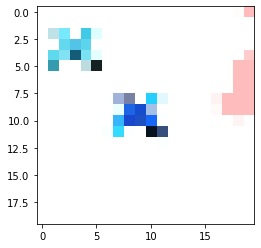

In [177]:
game_img = poe_bot.getImage()
plt.imshow(game_img[center_point_on_a_big_map[1]-10:center_point_on_a_big_map[1]+10, center_point_on_a_big_map[0]-10: center_point_on_a_big_map[0]+10])

In [178]:
poe_bot.bot_controls.mouseClick(pos_x, pos_y)

In [179]:
game_img = poe_bot.getImage()
npcs_and_doors = poe_bot.detectDoorsAndNPCS(game_img)

if len(npcs_and_doors) != 0:
  print('door detected')
  # stop then
  poe_bot.bot_controls.mouseRelease()
  pos_x, pos_y = poe_bot.getPosXY(center_point_on_a_big_map[0], center_point_on_a_big_map[1])
  poe_bot.bot_controls.mouseSetCursorPos(pos_x, pos_y)
  time.sleep(0.01)
  poe_bot.bot_controls.mouseClick(pos_x, pos_y)
  time.sleep(0.5)
  ret
  for i in range(1):
    game_img = poe_bot.getImage()
    npcs_and_doors = poe_bot.detectDoorsAndNPCS(game_img)
    if len(npcs_and_doors) == 0:
      break
    npcs_and_door = npcs_and_doors[0]
    pos_x, pos_y = poe_bot.getPosXY(npcs_and_door[1], npcs_and_door[0]+10)
    poe_bot.bot_controls.mouseSetCursorPos(pos_x, pos_y)
    time.sleep(0.01)
    poe_bot.bot_controls.mouseClick(pos_x, pos_y)
    time.sleep(0.5)

got screenshot from
door detected


NameError: name 'ret' is not defined

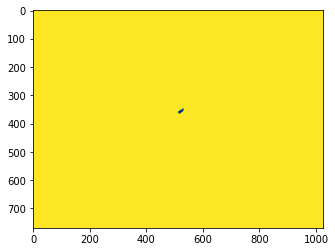

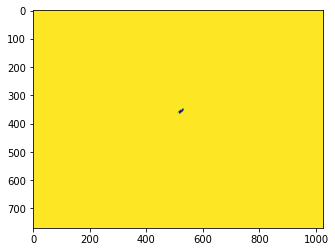

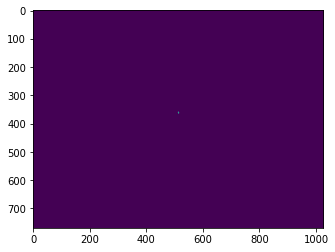

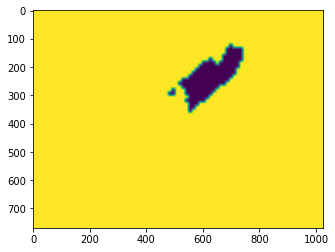

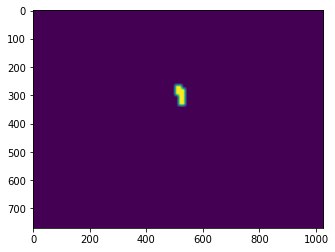

In [276]:
def zoom_center(img, zoom_factor=1.5):

    y_size = img.shape[0]
    x_size = img.shape[1]
    
    # define new boundaries
    x1 = int(0.5*x_size*(1-1/zoom_factor))
    x2 = int(x_size-0.5*x_size*(1-1/zoom_factor))
    y1 = int(0.5*y_size*(1-1/zoom_factor))
    y2 = int(y_size-0.5*y_size*(1-1/zoom_factor))

    # first crop image then scale
    img_cropped = img[y1-15:y2-15,x1:x2]
    return cv2.resize(img_cropped, (x_size, y_size), fx=zoom_factor, fy=zoom_factor)

astar_map_with_path = astar_map.copy()

astar_map_with_path[path_img != 0] = 255
zoomed_path_img = zoom_center(path_img,12)
zoomed_astar = zoom_center(astar_map_with_path,12)
plt.imshow(astar_map);plt.show()
plt.imshow(astar_map_with_path);plt.show()
plt.imshow(path_img);plt.show()
plt.imshow(zoomed_astar);plt.show()
plt.imshow(zoomed_path_img)

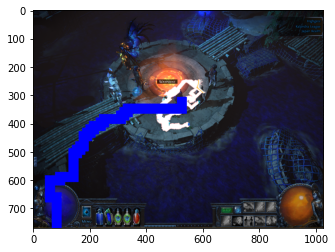

In [46]:
game_img_copy = game_img.copy()
game_img_copy[zoomed_path_img != 0] = (0,0,255)
plt.imshow(game_img_copy)

got screenshot from


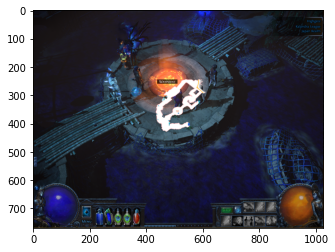

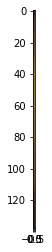

100


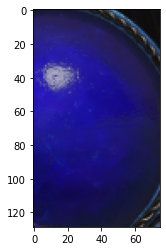

99.2248062015504


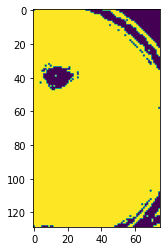

got screenshot from
100
[99.2248062015504, 100]
got screenshot from
[99.2248062015504, 100]


In [47]:
# GET HP MP
game_img = poe_bot.getImage()
plt.imshow(game_img);plt.show()
# f = open('./blue_drops.pickle', 'wb')
# pickle.dump(game_img, f)
# f.close()
# cropped_mp_bar = game_img[620:620+140, 900+30:]# VISIBLE
cropped_mp_bar = game_img[622:620+140, 900+30:900+31] # line only
plt.imshow(cropped_mp_bar);plt.show()

h1, s1, v1 = 94,130,54
h2, s2, v2 = 123,255,199
sorted_by_hsv = sortByHSV(cropped_mp_bar,h1, s1, v1, h2, s2, v2 )
mp_level = 100
pixel_value = 100/sorted_by_hsv.shape[0]
for i in sorted_by_hsv:
  if i[0] == 0:
    mp_level -= pixel_value
  else:
    break
print(mp_level)

cropped_hp_bar = game_img[620:620+130, 60+15:60+16] # line only
cropped_hp_bar = game_img[621:620+130, 60+15:150]# VISIBLE
plt.imshow(cropped_hp_bar);plt.show()

h1, s1, v1 = 0,116,0
h2, s2, v2 = 255,255,255
sorted_by_hsv = sortByHSV(cropped_hp_bar,h1, s1, v1, h2, s2, v2 )
hp_level = 100
pixel_value = 100/sorted_by_hsv.shape[0]
for i in sorted_by_hsv:
  if i[0] == 0:
    hp_level -= pixel_value
  else:
    break
print(hp_level)

plt.imshow(sorted_by_hsv);plt.show()

def getHPMP(game_img):
  cropped_mp_bar = game_img[622:620+140, 900+30:900+31] # line only
  h1, s1, v1 = 94,130,54
  h2, s2, v2 = 123,255,199
  sorted_by_hsv = sortByHSV(cropped_mp_bar,h1, s1, v1, h2, s2, v2 )
  mp_level = 100
  pixel_value = 100/140
  for i in sorted_by_hsv:
    if i[0] == 0:
      mp_level -= pixel_value
    else:
      break
  print(mp_level)

  cropped_hp_bar = game_img[620:620+130, 60+15:60+16] # line only
  cropped_hp_bar = game_img[621:620+130, 60+15:150]# VISIBLE

  h1, s1, v1 = 0,116,0
  h2, s2, v2 = 255,255,255
  sorted_by_hsv = sortByHSV(cropped_hp_bar,h1, s1, v1, h2, s2, v2 )
  hp_level = 100
  pixel_value = 100/sorted_by_hsv.shape[0]
  for i in sorted_by_hsv:
    if i[0] == 0:
      hp_level -= pixel_value
    else:
      break
  return [hp_level, mp_level]
print(getHPMP(poe_bot))
print(poe_bot.getHPMP())

got screenshot from


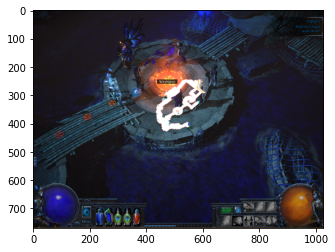

In [48]:
game_img = poe_bot.getImage()
plt.imshow(game_img);plt.show()
f = open('./blue_drops.pickle', 'wb')
pickle.dump(game_img, f)
f.close()

got screenshot from


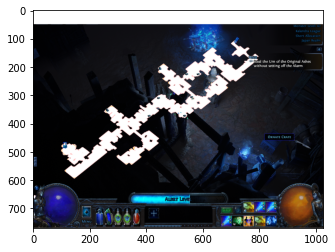

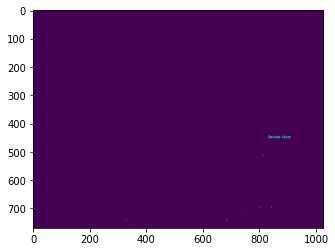

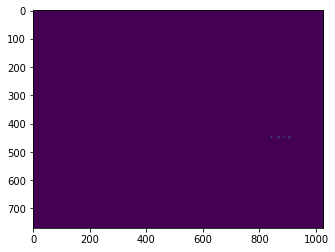

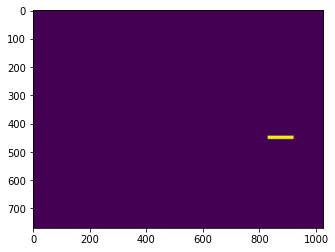

[(874, 449)]


In [204]:
def detectHeistChestOnScreen(game_img):
    game_img_copy = game_img.copy()
    game_img_copy[:50,:,:] = [255,255,255]

    # TODO get the doors only at the current area, skipping the outer one

    h1, s1, v1 = 21,130,149
    h2, s2, v2 = 24,147,208
    sorted_by_hsv = sortByHSV(game_img_copy,h1, s1, v1, h2, s2, v2 )
    kernel = np.ones((2,2),np.uint8)
    sorted_by_hsv = cv2.erode(sorted_by_hsv,kernel,iterations = 1)
    kernel = np.ones((3,9),np.uint8)
    sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 3)
    (contours, hierarchy) = cv2.findContours(
        sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # extracting enemy x and y coordinates from contours
    targets = [] # (x,y)
    for c in contours:
        if cv2.contourArea(c) > 50:
            x, y, w, h = cv2.boundingRect(c)
            target = (int(x + w / 2), int(y + h / 2))
            targets.append(target)

    return targets

# detecting heist chests on the screen
game_img = poe_bot.getImage()
game_img_copy = game_img.copy()
game_img_copy[:50,:,:] = [255,255,255]
plt.imshow(game_img_copy);plt.show()

# TODO get the doors only at the current area, skipping the outer one

h1, s1, v1 = 21,130,149
h2, s2, v2 = 24,147,208
sorted_by_hsv = sortByHSV(game_img_copy,h1, s1, v1, h2, s2, v2 )
plt.imshow(sorted_by_hsv);plt.show()
kernel = np.ones((2,2),np.uint8)
sorted_by_hsv = cv2.erode(sorted_by_hsv,kernel,iterations = 1)
plt.imshow(sorted_by_hsv);plt.show()
kernel = np.ones((3,9),np.uint8)
sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 3)
plt.imshow(sorted_by_hsv);plt.show()
(contours, hierarchy) = cv2.findContours(
    sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# extracting enemy x and y coordinates from contours
targets = [] # (x,y)
for c in contours:
    if cv2.contourArea(c) > 50:
        x, y, w, h = cv2.boundingRect(c)
        target = (int(x + w / 2), int(y + h / 2))
        targets.append(target)

print(targets)
pos_x, pos_y = poe_bot.getPosXY(targets[0][0], targets[0][1])
poe_bot.bot_controls.mouseClick(pos_x, pos_y)

In [ ]:
# detecting heist doors on the screen
game_img = poe_bot.getImage()
plt.imshow(game_img);plt.show()

# TODO get the doors only at the current area, skipping the outer one

h1, s1, v1 = 16,231,94
h2, s2, v2 = 28,243,173
sorted_by_hsv = sortByHSV(game_img,h1, s1, v1, h2, s2, v2 )
plt.imshow(sorted_by_hsv);plt.show()

In [ ]:
# detecting heist main target
game_img = poe_bot.getImage()
plt.imshow(game_img);plt.show()

# TODO get the doors only at the current area, skipping the outer one

h1, s1, v1 = 21,50,120
h2, s2, v2 = 24,69,179
sorted_by_hsv = sortByHSV(game_img,h1, s1, v1, h2, s2, v2 )
plt.imshow(sorted_by_hsv);plt.show()

h1, s1, v1 = 12,201,114
h2, s2, v2 = 14,215,189
sorted_by_hsv = sortByHSV(game_img,h1, s1, v1, h2, s2, v2 )
plt.imshow(sorted_by_hsv);plt.show()


h1, s1, v1 = 0,146,134
h2, s2, v2 = 0,255,224
sorted_by_hsv = sortByHSV(game_img,h1, s1, v1, h2, s2, v2 )
plt.imshow(sorted_by_hsv);plt.show()


h1, s1, v1 = 23,66,99
h2, s2, v2 = 26,82,128
sorted_by_hsv = sortByHSV(game_img,h1, s1, v1, h2, s2, v2 )
plt.imshow(sorted_by_hsv);plt.show()

In [ ]:
# detecting heist doors on the screen
game_img = poe_bot.getImage()
plt.imshow(game_img);plt.show()

# TODO get the doors only at the current area, skipping the outer one

h1, s1, v1 = 0,222,255
h2, s2, v2 = 0,255,255
sorted_by_hsv = sortByHLS(game_img,h1, s1, v1, h2, s2, v2 )
plt.imshow(sorted_by_hsv);plt.show()

got screenshot from


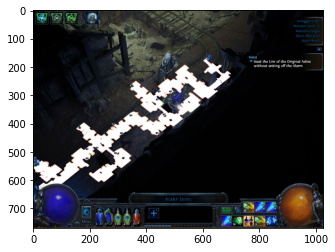

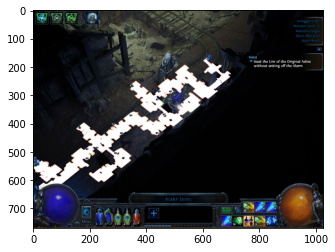

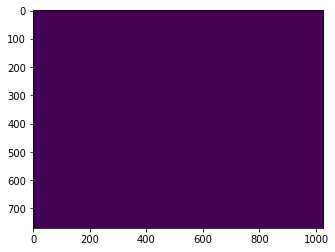

[]


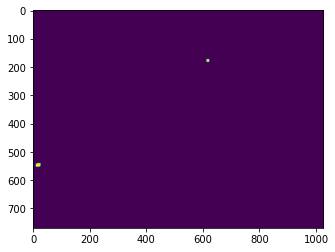

[(18, 546), (617, 178)]
got screenshot from


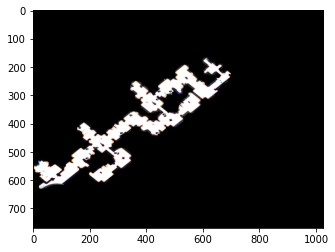

11
[]


In [146]:
def detectHeistExitTransitionArea(currently_passable_area_mask):
  # accepts map_mask
  h1, s1, v1 = 165,135,187
  h2, s2, v2 = 180,212,229
  sorted_by_hsv = sortByHSV(currently_passable_area_mask,h1, s1, v1, h2, s2, v2 )
  kernel = np.ones((10,10),np.uint8)
  sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
  (contours, hierarchy) = cv2.findContours(
    sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  targets = [] # (x,y)
  for c in contours:
      if cv2.contourArea(c) > 50:
          x, y, w, h = cv2.boundingRect(c)
          target = (int(x + w / 2), int(y + h / 2))
          targets.append(target)

  return targets

def detectHeistPrimaryTarget(currently_passable_area_mask):
  # accepts map_mask
  h1, s1, v1 = 14,255,201
  h2, s2, v2 = 24,255,248
  sorted_by_hsv = sortByHSV(currently_passable_area_mask,h1, s1, v1, h2, s2, v2 )
  kernel = np.ones((10,10),np.uint8)
  sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
  (contours, hierarchy) = cv2.findContours(
    sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  targets = [] # (x,y)
  for c in contours:
      if cv2.contourArea(c) > 50:
          x, y, w, h = cv2.boundingRect(c)
          target = (int(x + w / 2), int(y + h / 2))
          targets.append(target)

  return targets

f = open('./blue_drops.pickle', 'rb')
loaded_minimaps = pickle.load(f)
f.close()
game_img = loaded_minimaps
game_img = poe_bot.getImage()
plt.imshow(game_img);plt.show()
currently_passable_area_mask = poe_bot.getMapMask(game_img)
plt.imshow(game_img);plt.show()

h1, s1, v1 = 165,135,187
h2, s2, v2 = 180,212,229
sorted_by_hsv = sortByHSV(currently_passable_area_mask,h1, s1, v1, h2, s2, v2 )
kernel = np.ones((10,10),np.uint8)
sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
plt.imshow(sorted_by_hsv);plt.show()
(contours, hierarchy) = cv2.findContours(
    sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# extracting enemy x and y coordinates from contours
targets = [] # (x,y)
for c in contours:
    if cv2.contourArea(c) > 50:
        x, y, w, h = cv2.boundingRect(c)
        target = (int(x + w / 2), int(y + h / 2))
        targets.append(target)

print(targets)

# detectHeistPrimaryTarget
h1, s1, v1 = 12,255,206
h2, s2, v2 = 23,255,212

h1, s1, v1 = 14,255,201
h2, s2, v2 = 24,255,248
sorted_by_hsv = sortByHSV(currently_passable_area_mask,h1, s1, v1, h2, s2, v2 )
kernel = np.ones((10,10),np.uint8)
sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
plt.imshow(sorted_by_hsv);plt.show()
(contours, hierarchy) = cv2.findContours(
    sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# extracting enemy x and y coordinates from contours
targets = [] # (x,y)
for c in contours:
    if cv2.contourArea(c) > 50:
        x, y, w, h = cv2.boundingRect(c)
        target = (int(x + w / 2), int(y + h / 2))
        targets.append(target)

print(targets)

game_img = poe_bot.getMapMask()
plt.imshow(game_img);plt.show()
targets = detectHeistExitTransitionArea(game_img)
print(11)
print(targets)
# f = open('./getMapMask.pickle', 'wb')
# pickle.dump(game_img, f)
# f.close()

In [ ]:
game_img = poe_bot.getMapMask()
plt.imshow(game_img);plt.show()
targets = detectHeistExitTransitionArea(game_img)
print(11)
print(targets)
for target in targets:
  
  plt.imshow(game_img[target[1]-20:target[1]+20,target[0]-20:target[0]+20]);plt.show()

got screenshot from


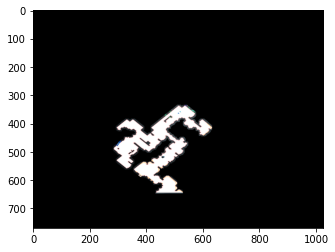

got screenshot from


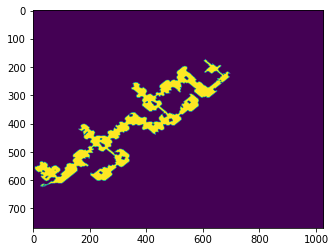

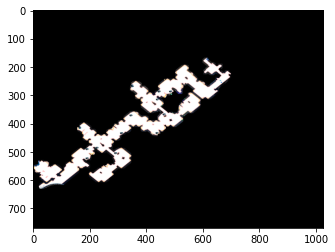

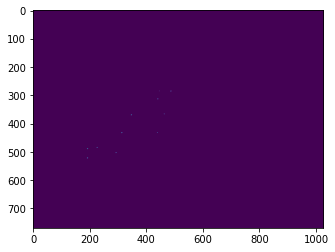

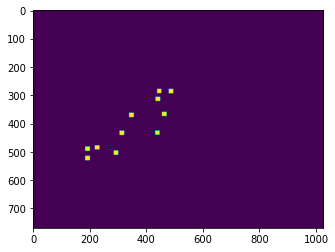

[(192, 522), (293, 503), (192, 489), (226, 484), (439, 432), (313, 433), (347, 370), (463, 366), (440, 313), (487, 286), (445, 285)]


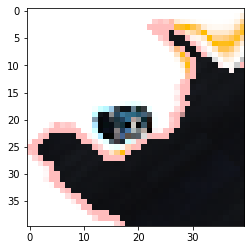

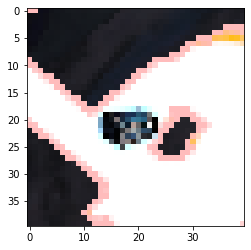

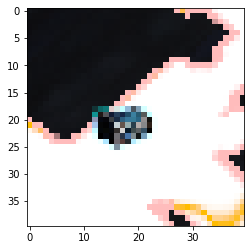

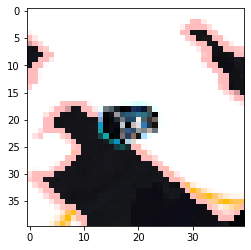

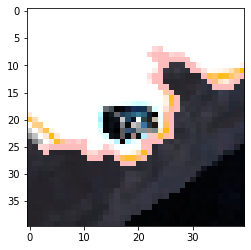

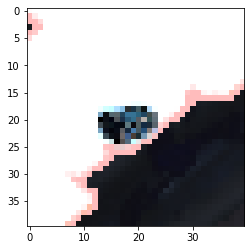

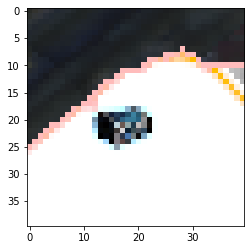

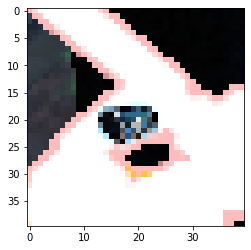

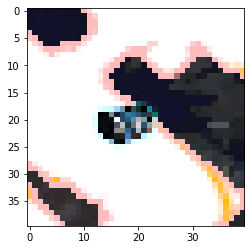

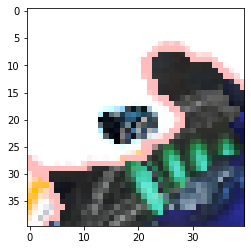

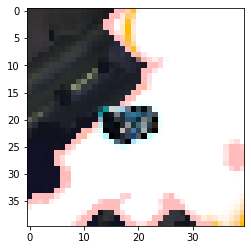

In [133]:
# detect small chest on the map

def detectSmallChests(currently_passable_area_mask):
  # currently_passable_area_mask
  h1, s1, v1 = 19,160,106
  h2, s2, v2 = 21,172,173
  sorted_by_hsv = sortByHSV(currently_passable_area_mask,h1, s1, v1, h2, s2, v2 )

  kernel = np.ones((10,10),np.uint8)
  sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
  (contours, hierarchy) = cv2.findContours(
      sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  targets = []
  for c in contours:
      if cv2.contourArea(c) > 50:
          x, y, w, h = cv2.boundingRect(c)
          target = (int(x + w / 2), int(y + h / 2))
          targets.append(target)
  return targets
game_img = poe_bot.getImage()


currently_passable_area = poe_bot.getPassableOnMap(game_img)
plt.imshow(currently_passable_area);plt.show()

currently_passable_area_mask = poe_bot.getMapMask(game_img, currently_passable_area)
plt.imshow(currently_passable_area_mask);plt.show()


h1, s1, v1 = 19,160,106
h2, s2, v2 = 21,172,173
sorted_by_hsv = sortByHSV(currently_passable_area_mask,h1, s1, v1, h2, s2, v2 )

plt.imshow(sorted_by_hsv);plt.show()
kernel = np.ones((15,15),np.uint8)
sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
plt.imshow(sorted_by_hsv);plt.show()
(contours, hierarchy) = cv2.findContours(
    sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
targets = []
for c in contours:
    if cv2.contourArea(c) > 50:
        x, y, w, h = cv2.boundingRect(c)
        target = (int(x + w / 2), int(y + h / 2))
        targets.append(target)

print(targets)
targets = detectSmallChests(currently_passable_area_mask)
for target in targets:
  
  plt.imshow(game_img[target[1]-20:target[1]+20,target[0]-20:target[0]+20]);plt.show()

In [22]:
input('smth')

'123'

In [ ]:
f = open('./blue_drops.pickle', 'rb')
# dict_keys(['minimap_initial', 'minimap_0', 'minimap_225', 'minimap_270'])
loaded_minimaps = pickle.load(f)
f.close()
game_img = loaded_minimaps
plt.imshow(game_img);plt.show()

h1, s1, v1 = 17,196,141
h2, s2, v2 = 38,255,255
sorted_by_hsv = sortByHSV(game_img,h1, s1, v1, h2, s2, v2 )
plt.imshow(sorted_by_hsv);plt.show()
kernel = np.ones((15,15),np.uint8)
sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
plt.imshow(sorted_by_hsv);plt.show()
game_img[sorted_by_hsv == 0] = [0,0,0]
plt.imshow(game_img)



got screenshot from


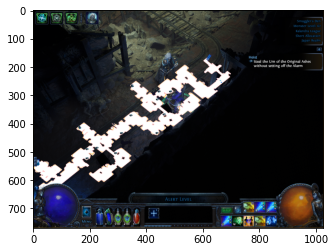

[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [0.9430156  0.9560882  0.93239385 ... 1.         1.         1.        ]
 [0.9487187  0.9531213  0.9713263  ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]


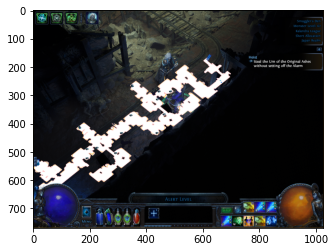

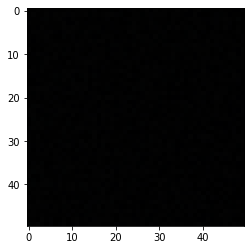

In [143]:
game_img = poe_bot.getImage()
plt.imshow(game_img);plt.show()

res = cv2.matchTemplate(game_img[:,:,0], heist_primary_target_image[:,:,0], cv2.TM_SQDIFF_NORMED)
print(res)
threshold = 0.3
loc = np.where( res <= threshold )
img_rgb = game_img.copy()
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + 100, pt[1] + 100), (0,0,255),-1)

plt.imshow(img_rgb);plt.show()
plt.imshow(img_rgb[450:500,800:850]);plt.show()

got screenshot from


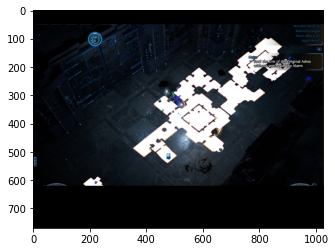

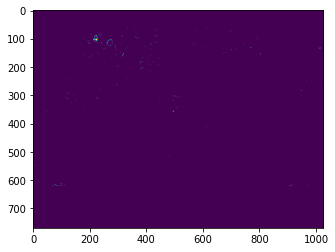

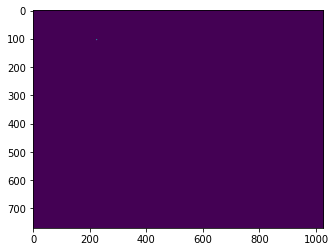

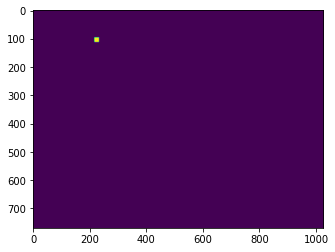

[(224, 104)]


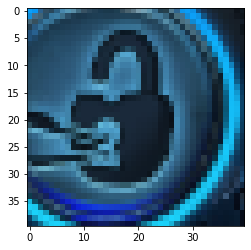

In [229]:
# detecting heist doors
def detectHeistDoors(game_img):
  game_img_copy = game_img.copy()
  game_img_copy[:50,:] = [0,0,0]
  game_img_copy[620:,:] = [0,0,0]
  plt.imshow(game_img_copy);plt.show()
  h1, s1, v1 = 5,139,52
  h2, s2, v2 = 31,149,85
  sorted_by_hsv = sortByHSV(game_img_copy,h1, s1, v1, h2, s2, v2 )
  plt.imshow(sorted_by_hsv);plt.show()
  kernel = np.ones((4,4),np.uint8)
  sorted_by_hsv = cv2.erode(sorted_by_hsv,kernel,iterations = 1)
  plt.imshow(sorted_by_hsv);plt.show()
  kernel = np.ones((15,15),np.uint8)
  sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
  plt.imshow(sorted_by_hsv);plt.show()
  (contours, hierarchy) = cv2.findContours(
      sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  targets = []
  for c in contours:
      if cv2.contourArea(c) > 50:
          x, y, w, h = cv2.boundingRect(c)
          target = (int(x + w / 2), int(y + h / 2))
          targets.append(target)

  return targets

game_img = poe_bot.getImage()
game_img_copy = game_img.copy()
game_img_copy[:50,:] = [0,0,0]
game_img_copy[620:,:] = [0,0,0]
plt.imshow(game_img_copy);plt.show()
h1, s1, v1 = 5,139,52
h2, s2, v2 = 31,149,85
sorted_by_hsv = sortByHSV(game_img_copy,h1, s1, v1, h2, s2, v2 )
plt.imshow(sorted_by_hsv);plt.show()
kernel = np.ones((4,4),np.uint8)
sorted_by_hsv = cv2.erode(sorted_by_hsv,kernel,iterations = 1)
plt.imshow(sorted_by_hsv);plt.show()
kernel = np.ones((15,15),np.uint8)
sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
plt.imshow(sorted_by_hsv);plt.show()
(contours, hierarchy) = cv2.findContours(
    sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
targets = []
for c in contours:
    if cv2.contourArea(c) > 50:
        x, y, w, h = cv2.boundingRect(c)
        target = (int(x + w / 2), int(y + h / 2))
        targets.append(target)

print(targets)
for target in targets:
  
  plt.imshow(game_img[target[1]-20:target[1]+20,target[0]-20:target[0]+20]);plt.show()



got screenshot from


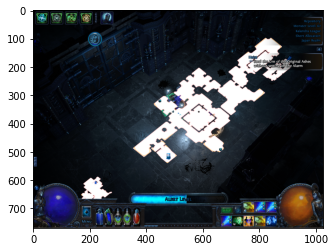

In [222]:
game_img = poe_bot.getImage()
plt.imshow(game_img)
f = open('./blue_drops.pickle', 'wb')
pickle.dump(game_img, f)
f.close()


In [147]:
game_img = poe_bot.getMapMask()
plt.imshow(game_img)
f = open('./blue_drops.pickle', 'wb')
pickle.dump(game_img, f)
f.close()
h1, s1, v1 = 14,203,142
h2, s2, v2 = 28,252,245
sorted_by_hsv = sortByHSV(game_img,h1, s1, v1, h2, s2, v2 )
plt.imshow(sorted_by_hsv);plt.show()
kernel = np.ones((2,4),np.uint8)
sorted_by_hsv = cv2.erode(sorted_by_hsv,kernel,iterations = 1)
plt.imshow(sorted_by_hsv);plt.show()
kernel = np.ones((15,15),np.uint8)
sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 1)
plt.imshow(sorted_by_hsv);plt.show()
(contours, hierarchy) = cv2.findContours(
    sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
targets = []
for c in contours:
    if cv2.contourArea(c) > 50:
        x, y, w, h = cv2.boundingRect(c)
        target = (int(x + w / 2), int(y + h / 2))
        targets.append(target)

print(targets)
for target in targets:
  
  plt.imshow(game_img[target[1]-20:target[1]+20,target[0]-20:target[0]+20]);plt.show()

got screenshot from


IndexError: list index out of range